# Part 1: Modeling Challenge

## i) Python Coding and Data Set

### Load in the data file, load in the header file and attach it to the dataframe

In [1]:
import os
import copy

import numpy as np
import pandas as pd

from sklearn import preprocessing
import scipy.stats as stats
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Changing working directory to where the input and output files are saved
folder_path = 'C:/Users/Chen/Documents/DS Projects/DS Instructor'
working_dir = os.chdir(folder_path)

In [3]:
#Loading input files
df_colhead = pd.read_csv('field_names.txt',header=None)
df_cancer = pd.read_csv('breast-cancer.csv',header=None)
#reassign header for df_cancer using first column values of df_colhead
df_cancer.columns=df_colhead.iloc[:,0]

### Comment on any steps you might take to evaluate or transform the dataset.

Garbage in garbage out, so ensuring that the data quality is good should be the first step. 

Two common ways that may contribute to bad quality data are:
1. Missing data points. For instance, if the record is corrupted.
2. Not missing but erroneous data points. For example, recording error that could sometimes show up as outliers.

Once bad quality data are identified, we would next need to impute them instead of leaving them as NaN. This is because most of the machine learning algorithms do not work well with NaN data points. 

In [4]:
#Check for missing data
print('Is there any data that are missing:')
print(str(df_cancer.isna().values.any()))
print(str(df_cancer.isnull().values.any()))

Is there any data that are missing:
False
False


In [5]:
#Check for any outliers using z score (|score|>3)

#Make a copy of the original - used later to contrast against the dataset with outlier removed
x_transformed = df_cancer.iloc[:,2:]
x_original = copy.deepcopy(df_cancer.iloc[:,2:]) 

#transform x into z scores
scaler = preprocessing.scale
x_scaled = abs(x_original.apply(lambda x: scaler(x)))

#Remove outliers, and then use KNN to impute back the value using the 3 nearest rows
x_transformed[x_scaled>3] = np.nan
imputer = KNNImputer(n_neighbors=3)
x_transformed = imputer.fit_transform(x_transformed)
df_cancer.iloc[:,2:] = x_transformed

Diagnostic plot to ensure that the data with outlier removed still resembles the original set. Take-aways:
- Only a small % of values within each column are removed and imputed (<2%)
- No change in distribution of the columns after imputation, as indicated by KS test

['p-values of ks test: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.\n 1. 1. 1. 1. 1. 1.]']


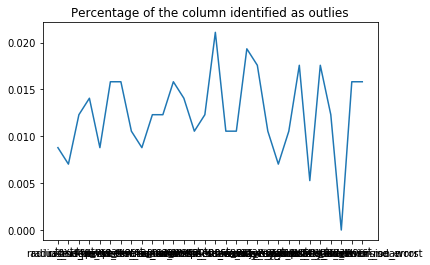

In [6]:
#<2% in any one column are identified as outliers and removed,
x_NOutlier = (x_scaled>3).astype(int)
P_outlier = x_NOutlier.sum(axis=0)/x_original.shape[0]
plt.title('Percentage of the column identified as outlies')
plt.plot(P_outlier)

#no change in overall distribution of the columns by Kolmogorov-Smirnov test
x_kstest = [stats.ks_2samp(x_original.iloc[:,col],x_transformed[:,col]).pvalue for col in range(x_original.shape[1])]
print(['p-values of ks test: '+str(np.round(x_kstest,2))])

### Compute the mean and median smoothness and compactness for benign and malignant tumors - do they differ? Explain how you would identify this.

In [7]:
c_smooth = df_cancer.smoothness_mean
c_compact = df_cancer.compactness_mean
i_M = df_cancer['diagnosis']=='M'
i_B = df_cancer['diagnosis']=='B'

print('[Smoothness, compactness] Mean for benign: ' + str(df_cancer[i_B][['smoothness_mean','compactness_mean']].mean(axis=0).values))
print('[Smoothness, compactness] Mean for malignant: ' + str(df_cancer[i_M][['smoothness_mean','compactness_mean']].mean(axis=0).values))
print('[Smoothness, compactness] Median for benign: ' + str(df_cancer[i_B][['smoothness_mean','compactness_mean']].median(axis=0).values))
print('[Smoothness, compactness] Median for malignant: ' + str(df_cancer[i_M][['smoothness_mean','compactness_mean']].median(axis=0).values))

[Smoothness, compactness] Mean for benign: [2.00032129 0.02048892]
[Smoothness, compactness] Mean for malignant: [4.08172642 0.03052756]
[Smoothness, compactness] Median for benign: [1.851   0.01631]
[Smoothness, compactness] Median for malignant: [3.6425  0.02859]


Hypothesis testing for mean and median are usually done using t-test and ranksum test. If p value < 0.05, then we have sufficient evidence to say that they are different.

In [8]:
#We can test this null hypothesis that mean and median do not differ using t-test and rank-sum test respectively.
print([str("Differ in smoothness mean: ")+str(ttest_ind(c_smooth[i_M],c_smooth[i_B]).pvalue<0.05)])
print([str("Differ in compactness mean: ")+str(ttest_ind(c_compact[i_M],c_compact[i_B]).pvalue<0.05)])

print([str("Differ in smoothness median: ")+str(ranksums(c_smooth[i_M],c_smooth[i_B]).pvalue<0.05)])
print([str("Differ in compactness median: ")+str(ranksums(c_compact[i_M],c_compact[i_B]).pvalue<0.05)])

['Differ in smoothness mean: True']
['Differ in compactness mean: True']
['Differ in smoothness median: True']
['Differ in compactness median: True']


### Write a function to generate bootstrap samples of the data.

Bootstrap function is usually used as a non-parametric estimation of dispersion, and is usually coupled with a function of interest (e.g., mean, median, or more complicated functions like survival rate).

The boot function below takes the following inputs:
- x is the input data
- boot_func defines the function of interest
- nboot is the number of bootstrapped samples (with replacement) - rule of thumb nboot=10,000 or greater



In [9]:
#Bootstrap function
def boot(x,nboot,boot_func=[]):
    """ This function takes a variable x, 
    sample it with replacement nboot times, 
    and return the calcuations defined by boot_func for each nboot sample. 
    """
    if callable(boot_func):
        boot_x = np.repeat(np.nan,nboot) #This step speed up the loop by predefining size of vector
        for i in range(nboot):
            xs = np.random.choice(x,len(x),replace=True)
            boot_x[i] = boot_func(xs)
    else:
        boot_x = [np.random.choice(x,len(x),replace=True) for i in range(nboot)]
    return boot_x

Boostrap demo: generating the SE of mean for c_smooth using bootstrap

In [10]:
diff_x_boot = boot(x=c_smooth,nboot=10000,boot_func=np.mean)
SE95 = np.percentile(diff_x_boot,[2.5,97.5])
print([str('SE of mean: ')+str(SE95)])

['SE of mean: [2.64563683 2.9125903 ]']


## ii) Exploratory Analysis

### Identify 2-3 variables that are predictive of a malignant tumor.

To quickly identify variables of interest for this exercise, I used univariate SelectKBest function to rank features using classical ANOVA (f_classif).

In [12]:
#Separate the independent and dependent variables
y = df_cancer['diagnosis']
x = df_cancer.drop(['diagnosis','ID'],axis=1)

In [13]:
#Using SelectKBest to identify top 3 variables that have predictive power
selector = SelectKBest(f_classif, k=3)
selector.fit(x,y)
x_index = selector.get_support(indices=True)
x_kbest = x.iloc[:,x_index]

### Display the relationship visually and write 1-2 sentences explaining the relationship.

Because this is a univariate analysis, features that are ranked highest can sometimes be highly correlated. In fact, this is the case, as seen by the correlation matrix.

In [14]:
x_kbest.corr()

,perimeter_sd_error,concave_points_sd_error,fractal_dimension_mean
0,,,
perimeter_sd_error,1.000000,0.846228,0.910467
concave_points_sd_error,0.846228,1.000000,0.818455
fractal_dimension_mean,0.910467,0.818455,1.000000


The top 3 variables are plotted, with different colors to separate cases that are malignant vs benign. In the pair plots, you can see how the variables are correlated, with malignant vs benign separated along the diagonals.

Since variables that are highly correlated often convey similar information, in the modelling section that follows, perhaps we can use PCA to create a set of features.

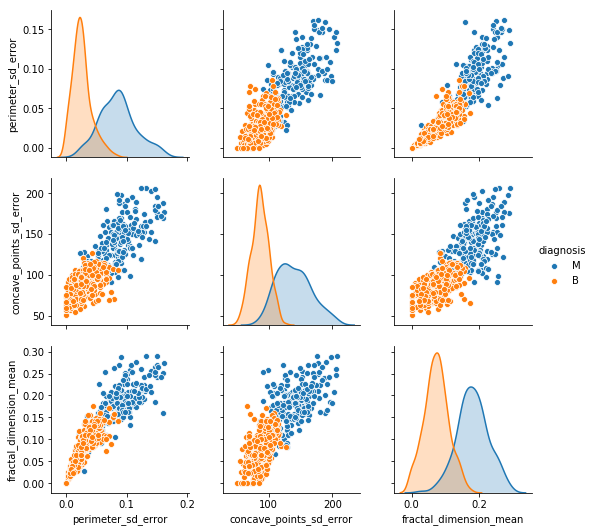

In [15]:
sns.pairplot(df_cancer,hue='diagnosis',vars=x_kbest.columns)

## iii) Modeling

### Build a model to predict the malignant tumors.

We will use two classification techniques, logistic regression and random forest. The two techniques not only differ in their methodology, they also differ in "culture" as stated by Leo Breiman (see Statistical Modeling: The Two Cultures).

A bit of historical and philosophical side note:

The traditional way, like logistic regression, emphasize on having a correct understanding of how the data enables prediction - a lot of parametric assumptions are used, such as whether the process is Poisson and i.i.d. etc. While the "modern" approach like random forest focuses mainly on finding the optimal hyperparameters to minize cross-validation error.

Although random forest may beat logistic regression in accuracy, this doesn't mean random forest "correctly" modeled reality. For instance, accurate navigation systems were developed based on a geocentric (earth centered) view even though the underlying theory is incorrect. 

We see a lot of this in image recognition, where a well-trained machine learning model gets thrown off by placing a piece of paper on the screen - and hence why there is a need for GAN models.

#### Splitting tesing set from training set, so that we can evaluate the performance of each model

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

### Technique 1: Classifical Logistic Regression

#### Feature engineering (PCA)

Due to high correlations between variables, PCA is performed to address multicollinearity. Theoretically, doing this enables us to maximize the information while reducing dimensionality and sparsity.

The first 10 components form the "elbow" and explain 95% of the variation. Thus, the first 10 components will be used for logistic regression. 

In [17]:
print(X_train.corr()) 

#PCA transform the x feature matrixes into orthogonal components
pca = decomposition.PCA()
x_train_Scaled = X_train.apply(lambda x: scaler(x))
x_train_scaled_pca = pca.fit_transform(x_train_Scaled)
x_test_Scaled = X_test.apply(lambda x: scaler(x))
x_test_scaled_pca = pca.fit_transform(x_test_Scaled)

0                           radius_mean  radius_sd_error  radius_worst  \
0                                                                        
radius_mean                    1.000000         0.329248      0.996143   
radius_sd_error                0.329248         1.000000      0.338343   
radius_worst                   0.996143         0.338343      1.000000   
texture_mean                   0.991308         0.337479      0.988567   
texture_sd_error               0.210909        -0.012024      0.247277   
texture_worst                  0.515040         0.227337      0.562299   
perimeter_mean                 0.665260         0.303921      0.704282   
perimeter_sd_error             0.814698         0.291787      0.844670   
perimeter_worst                0.156120         0.093717      0.189829   
area_mean                     -0.256216        -0.049496     -0.209412   
area_sd_error                  0.684559         0.299300      0.693384   
area_worst                    -0.12598

['% of variable explained by first 10 PC: 0.9405822830962658']


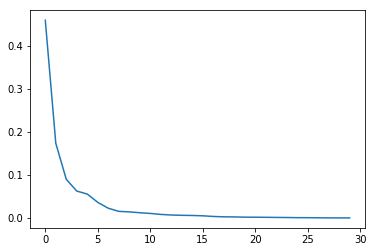

In [18]:
#Determine the number of principle components to include
plt.plot(pca.fit(x_train_Scaled).explained_variance_ratio_)
print(['% of variable explained by first 10 PC: '+str(np.sum(pca.fit(x_train_Scaled).explained_variance_ratio_[0:10]))])

#### Fitting logistic regression with regularization to control for overfitting

A straight out fitting is not ideal because there is a chance that the model might overfit. In other words, the pattern that the function captures might not generalize, and therefore generating high error rate in the testing set.

One way to address this is to use regularization to penalize the betas in order to reduce cross-validation error. In this demo, I picked l2 regularization and tuned the hyperparameters using 10 fold cross validation.

In [19]:
LogReg2 = LogisticRegressionCV(solver='saga',max_iter=4000,penalty='l2',cv=10).fit(x_train_scaled_pca[:,0:10],Y_train)

#### Feature importance

The magnitude of coefficient measures the unit change in probability of having cancer, and could be used to rank the importance of the PCA components used as predictors. However, to rank the importance of individual 30 variables that makes up each PCA component, we have to also consider the PCA loadings. 

Here, the first two principal components are the most important - no surprise here. Within the first PCA component, 'fractal_dimension_sd_error' appears to be the most important variable.

In [20]:
#The first two principle components has the highest |coef|
print(abs(LogReg2.coef_))

#Of the variables that goes into the first compoents, fractal_dimension_worst appears to be most important
i_features_PC1 = abs(pca.components_[:,0:1] * np.sqrt(pca.explained_variance_[0:1])).argmax(axis=0)
print(X_train.columns[i_features_PC1])

[[1.90483813 0.87710324 0.21019663 0.70472804 0.74795835 0.44474781
  0.1371806  0.08166937 0.34005723 0.47472698]]
Index(['fractal_dimension_sd_error'], dtype='object', name=0)


To rank the importance for individual 30 variables, we can combine the coefficient magnitude AND the PCA loadings. This works because both logistic regression and PCA are both linear transformations.
    
Here, we see that the top 3 variables are: fractal_dimension_sd_error, fractal_dimension_worst, concavity_worst

In [22]:
#Compute and rank the 30 variables in order of their importance
score_x_features = np.sum(abs(pca.components_[:,0:10] * np.sqrt(pca.explained_variance_[0:10])*LogReg2.coef_),axis=1)
i_features = score_x_features.argsort(axis=0)[-3:]

#Extract the top three features
X_train.columns[i_features]

Index(['concavity_worst', 'fractal_dimension_worst',
       'fractal_dimension_sd_error'],
      dtype='object', name=0)

#### Model performance evaluate

A common way to evaluate classification models is by looking at the accuracy score and the confusion matrix.

While accuracy score provides a nice one-number summary, where the model with higher accuracy is better, the confusion matrix provides more insight.

Below is the definition of the outputs by the confusion matrix, taken from https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/:

- true positives (TP): Cases that are correctly predicted to have disease.
- true negatives (TN): Cases that are correctly predicted to have no disease.
- false positives (FP): We predicted yes, but they don't actually have the disease.
- false negatives (FN): We predicted no, but they actually do have the disease.


In [23]:
c_matrix_log = confusion_matrix(LogReg2.predict(x_test_scaled_pca[:,0:10]),Y_test)
a_score_log = accuracy_score(LogReg2.predict(x_test_scaled_pca[:,0:10]),Y_test)

print(['tn, fp, fn, tp: '+str(c_matrix_log.ravel())])
print(['accuracy for testing set: '+str(a_score_log)])

['tn, fp, fn, tp: [66  2  1 45]']
['accuracy for testing set: 0.9736842105263158']


### Technique 2: Random forest


#### Hyperparameter tuning using gridsearch

Compare to logistic regression, random forest has more hyperparameters to tune and thus requires more resources/time to train. 

These hyperparameters also provide the model with more flexibility, and thus we don't need to worry as much about feature engineering. Plus, it is a non-linear decision tree model and thus could handle the multicollinearity issue better than the linear logistic approach. 

Hence we aren't going to focus too much on feature engineering, but rather let's spend time on hyperparameter tunning using gridsearch and cross-validation.

In [24]:
#Initialize the hyperparameters to try, and using 5-fold cross-validation to find the most optimial combinations.
#Due to time constrain, we only look at a selective set of possible hyperparameters
param_grid = { 'n_estimators': [100, 500, 900],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [10, 50, 100, None],}
rfc=RandomForestClassifier(random_state=0)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, Y_train)

#Display the best parameters
print(CV_rfc.best_params_)

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}


#### Random forest decision tree fitting

Once we found our optimal hyperparameters, we can then input them into our random forest algorithm and construct our model. 

Briefly, random forest works by building many many decision trees (n_estimators determines the number of trees). Each tree is trained on a slightly different set of data, and each tree would "vote" on whether the tumor is malignant or not. In the end, the cancer class is classified based on the majority's pick.

In [25]:
rfc_best = RandomForestClassifier(random_state=0,n_estimators=100,max_features='auto',max_depth=10)
rfc_best.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Feature importance

Because random forest models are a collection of models (i.e., ensemble method), the importance of each feature is determined by both:
1. The frequency of that feature being selected
2. When selected, the impact of that feature on improving the fit.

Here, the top three features identified to be important under random forest are: concave_points_sd_error, fractal_dimension_mean, concavity_worst.

In [26]:
i_rfc_topfs = rfc_best.feature_importances_.argsort()[-3:]
X_train.columns[i_rfc_topfs]

Index(['concavity_worst', 'fractal_dimension_mean', 'concave_points_sd_error'], dtype='object', name=0)

#### Model performance

Using the same metrics as logistic regression, we can now compare the two models.

Interestingly, both logistic and random forest produce very similar accuracy and confusion matrix score.

In [27]:
#Model performance for random forest model on testing dataset

c_matrix_rf = confusion_matrix(rfc_best.predict(X_test),Y_test)
a_score_rf = accuracy_score(rfc_best.predict(X_test),Y_test)

print(['tn, fp, fn, tp: '+str(c_matrix_rf.ravel())])
print(['accuracy for testing set: '+str(a_score_rf)])

['tn, fp, fn, tp: [67  4  0 43]']
['accuracy for testing set: 0.9649122807017544']


In [28]:
#Compare to the logistic model on testing dataset
print(['tn, fp, fn, tp: '+str(c_matrix_log.ravel())])
print(['accuracy for testing set: '+str(a_score_log)])

['tn, fp, fn, tp: [66  2  1 45]']
['accuracy for testing set: 0.9736842105263158']


## iv) Explanation

#### Technical Audiences: Explain the limitations of your analysis and identify possible further steps you could take

1. The lack of metadata and methodology

Starting from the data, one of the limitations is not having a full set of metadata to help understand the features, as well as methods detailing how the variables are collected. These insights are important in forming an idea on how to engineer features, and how to interpret the results. 

Another concern is whether or not the sample is biased. For instance, western studies are done for patients who are predominately caucasian. Thus, the results may not generalize well to patients of different ethnicity.

2. Switch to a multivariable non-parametric outlier detection method

The z-score approach used to identify outliers has the following limitations:
- This method does not consider the correlation between columns.
- Multiple comparison problem: computing z scores independently for 30 columns increase the chance of false positives.
- z score assumes a normal distribution and does not work well with skewed data. A non-parametric clustering approach would work better.

If time allows, I would investigate using DBScan to detect outliers.

3. Improve hyperparameter search space and speed using genetic algorithm

Gridsearch is an exhaustive search function, and this function becomes very expensive when we start to increase the number of hyperparameters (NP-complete problem). A faster and more efficient way to solve this problem would be to apply the genetic algorithm. This type of algorithm is designed to solve these NP problems, and have shown success in studies published.

Switching from gridsearch to genetic algorithm could help to improve model performance for random forest by searching for a broader set of hyperparameters.

4. Power analysis to determine where we lack data

My gut feeling is that with 30 different features, the data might be too sparse, and there could be improvements made by increasing sample size. Power analysis could be employed to further answer this question.

#### Non-Technical Audiences: Write a short summary of your analysis, explaining how your model works and how it performs.

##### We can see that the dataset contains enough information to accurately predict whether tumors are malignant or benign.

We first saw this in our exploratory analysis, where we can visually see a clear separation between malignant and benign tumors with features like fractal_dimension_mean. Using multivariant models (logistic and random forest), we are able to predict correct cases with 97% accuracy. 

The variable fractal_dimension kept showing up as an important feature. Under logistic regression, fractal_dimension_worst is one of the top important variables and under random forest, fractal_dimension_mean was identified as one of the top 3.

A quick google search shows that fractal dimension seems to be measuring the tumor's irregular shape, and it is one of the criteria used to identify breast cancer (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6349609/). This supports our findings.


##### Although both models gave very similar results, what's under the hood is different.

The logistic model is a traditional method used for classification. Here, the model predicts the probability of tumors being malignant, and the impact of each feature in determining the probability (i.e., betas). 

Random forest also predicts the probability that the tumor is malignant. It does so by constructing many set of models using data set that are slightly different. The probability of a tumor being malignant is then estimated based on the percentage of votes from each model - much like an election. However, the impact of each variable is not clear. 

Hence why logistic model are often considered to be more interpretable, while random forest is considered to be a "black-box".